In [2]:
from maap.maap import MAAP
#maap = MAAP(maap_host='api.ops.maap-project.org')
maap = MAAP()

In [3]:
maap._MAAP_HOST

'api.maap-project.org'

In [4]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

# Launch DPS for build_stack.py

In [5]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade

In [6]:
import os
import geopandas
import pandas as pd
import glob
import datetime
!pip install xmltodict
import xmltodict
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils

NASA MAAP


In [7]:
import s3fs
s3fs.__version__

'2023.12.0'

# Test (locally) the script for DPS

##### To run build_stack.py across a tiled raster dataset you need a bunch of args that we'll gather into a dictionary

s3 you need to have a vector footprint of that dataset

In [8]:
TILE_NUM = 3459 #354000 #685 # tmp2.gpkg has the subtiles in siberia for this boreal tile

#### Dictionary preparation makes this script very flexible and transferable to another s3 dataset
This dictionary is specific to the ESA Worldcover dataset.  
To run '`build_stack.py` across another dataset, just prepare another dictionary here and everything below should be exactly the same.  

In [9]:
BUILD_STACK_DICT_S1 = {
            # Test S1 on tile 3736 in western AK where subtiles overlap near AGG tile boundary 
            'INDEX_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
            'ID_COL_NAME': 'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR': 'boreal_tiles_v004',
            'COVAR_SRC_NAME': 'SAR_S1_2018',
            'BANDNAMES_LIST': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer', # TODO: NOT SURE what this should be yet... all 6 bands? just 'vh'?
            #'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tiles_lists/SAR/EXPORT_GEE_v3/SAR_S1_2018/S1_tindex_master.gpkg',
            'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v3/SAR_S1_2018/S1_tindex_master.gpkg',
            # 'COVAR_TILE_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/SAR/TEST/S1_tindex_master.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'OUTDIR': '/projects/shared-buckets/montesano/local_output/build_stack_S1',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        }

In [10]:
# run_extract_atl08_orig_ubuntu | export_gee_to_maap_v2
#!aws s3 mv --recursive s3://maap-ops-workspace/shared/montesano/run_extract_atl08_orig_ubuntu s3://maap-ops-workspace/shared/montesano/local_output/
##!aws s3 mv --recursive s3://maap-ops-workspace/shared/montesano/local_output/master s3://maap-ops-workspace/shared/montesano/local_output/run_extract_atl08_orig_ubuntu/master/
#!aws s3 cp --recursive s3://maap-ops-workspace/shared/montesano/local_output/do_gee_download_by_subtile_TEST2 s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2
#!aws s3 cp --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2/ 
#!aws s3 mv --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2/ s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/TEST/2023/12/16/1/1

In [11]:
BUILD_STACK_DICT = BUILD_STACK_DICT_S1
BUILD_STACK_DICT

{'INDEX_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
 'ID_COL_NAME': 'tile_num',
 'TILE_NUM': 3459,
 'INDEX_LYR': 'boreal_tiles_v004',
 'COVAR_SRC_NAME': 'SAR_S1_2018',
 'BANDNAMES_LIST': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer',
 'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v3/SAR_S1_2018/S1_tindex_master.gpkg',
 'IN_COVAR_S3_COL': 's3_path',
 'OUTDIR': '/projects/shared-buckets/montesano/local_output/build_stack_S1',
 'NODATA_VAL': 0,
 'OUTPUT_CLIP_COG_FN': '',
 'CREDENTIALS_FN': None}

In [ ]:
boreal_tiles = geopandas.read_file(BUILD_STACK_DICT['INDEX_FN'])
boreal_tiles.explore()

<Axes: >

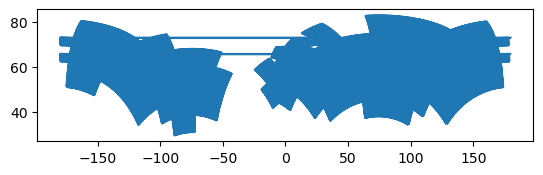

In [49]:
covar_tile_gdf = geopandas.read_file(BUILD_STACK_DICT['COVAR_TILE_FN'])
covar_tile_gdf.boundary.plot()

In [74]:
# INDEX clip shapes should be in equal area
# COVAR_TILE_FN tiles (of raster COGs) should be in 4326
args = f"\
    --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o {BUILD_STACK_DICT['OUTDIR']} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['COVAR_SRC_NAME']} \
    --bandnames_list {BUILD_STACK_DICT['BANDNAMES_LIST']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip"
    #--shape 3000 \
    #--clip"
BUILD_STACK_DICT['BANDNAMES_LIST']

'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer'

In [ ]:
!/projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_stack.py $args

In [12]:
DPS_INPUT_TILE_NUM_LIST = []

### Use MAAP Registration call in notebook chunk to register DPS algorithm
 - We need to register a DPS algorithm called `run_build_stack_LC` before proceeding to the chunks below...

In [17]:
maap.register_algorithm_from_yaml_file("/projects/code/icesat2_boreal/dps/registered/run_build_stack.yml").text

'{"code": 200, "message": {"id": "eb27331e51024d5ea59700ef5edc8550451ff99b", "short_id": "eb27331e", "created_at": "2023-12-28T02:12:47.000+00:00", "parent_ids": ["89b943ee4e6bbcbfb0f4abf177f2ce59a0791573"], "title": "Registering algorithm: run_build_stack", "message": "Registering algorithm: run_build_stack", "author_name": "root", "author_email": "root@909fdfe9cc27", "authored_date": "2023-12-28T02:12:47.000+00:00", "committer_name": "root", "committer_email": "root@909fdfe9cc27", "committed_date": "2023-12-28T02:12:47.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/eb27331e51024d5ea59700ef5edc8550451ff99b", "stats": {"additions": 0, "deletions": 0, "total": 0}, "status": "running", "project_id": 3, "last_pipeline": {"id": 10909, "iid": 673, "project_id": 3, "sha": "eb27331e51024d5ea59700ef5edc8550451ff99b", "ref": "main", "status": "running", "source": "push", "created_at": "2023-12-28T02:12:48.531Z", "updated_at": "2023-12-2

In [1]:
#!aws s3 rm --recursive s3://maap-ops-workspace/montesano/dps_output/run_build_stack/LC_ESA_WC_2020
#!aws s3 mv s3://maap-ops-workspace/montesano/dps_output/run_build_stack/LC_ESA_WC_2020 s3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023

# Build a DPS list

In [13]:
#HLS_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv".replace('s3://maap-ops-workspace/shared/nathanmthomas', '/projects/my-public-bucket')
Topo_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv" #.replace('s3://maap-ops-workspace/shared/nathanmthomas', '/projects/my-public-bucket')

# Spring 2022 c2020 composite - use this as template set of tiles (5241 tiles)
HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master.csv'

s3 = s3fs.S3FileSystem(anon=True)

DPS_INPUT_TILE_NUM_LIST = []
for tindex_fn in [HLS_EXISTING_TINDEX_FN, Topo_tindex_master_fn]:
    tindex = pd.read_csv(tindex_fn, storage_options={'anon':True})
    
    print(len(tindex['tile_num'].values))
    
    if len(tindex['tile_num'].values) > len(DPS_INPUT_TILE_NUM_LIST):
        print(f"{len(tindex['tile_num'].values)} tiles in {tindex_fn}")
        print(f'{os.path.basename(tindex_fn)} has the most tiles. Using this for DPS tiles list.')
        DPS_INPUT_TILE_NUM_LIST = tindex['tile_num'].values

len(DPS_INPUT_TILE_NUM_LIST)
TILES_NEEDED = DPS_INPUT_TILE_NUM_LIST

5241
5241 tiles in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master.csv
HLS_tindex_master.csv has the most tiles. Using this for DPS tiles list.
5220


In [14]:
RUN_IRREGULAR_TILES = False

IRREGULAR_TILES_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv'

if RUN_IRREGULAR_TILES:
    DPS_INPUT_TILE_NUM_LIST = []
    print("Running DPS on irregular tiles that forces a shape of 3000...")
    df = pd.read_csv(IRREGULAR_TILES_FN)
    tile_num_list = []
    for i in df["IrregularTiles"]:
        tile_num = int(i.split('_')[9])
        DPS_INPUT_TILE_NUM_LIST.append(tile_num)
    print(len(DPS_INPUT_TILE_NUM_LIST))
    print(DPS_INPUT_TILE_NUM_LIST)

In [15]:
len(DPS_INPUT_TILE_NUM_LIST)

5241

#### Note: make sure the `in_params_dict` coincides with the args of `build_stack.py`

In [16]:
#'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg',
in_params_dict = {
            'covar_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v3/SAR_S1_2018/S1_tindex_master.gpkg',
            'in_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
            'covar_tile_fn': 'S1_tindex_master.gpkg',
            'in_tile_fn': 'boreal_tiles_v004.gpkg',
            'in_tile_id_col': 'tile_num',
            'in_tile_num':"",
            'tile_buffer_m': 0,
            'in_tile_layer': 'boreal_tiles_v004',
            #'output_dir': 'dummy',  # a dummy dir so i dont have to change the .yaml now
            #'topo_off': 'dummy', # functionality to turn off build a 'topo' stack is FALSE by default - so we have to set this flag (which turns OFF topo building) - this is hardcoded in the .sh now - if we want to build a topo stack with this script, need to learn how to set this flag with params dict 
            'covar_src_name': 'SAR_S1_2018',
            'bandnames_list': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer',
            'in_covar_s3_col': 's3_path',
            'input_nodata_value': -9999,
            'shape': 3000
            #'clip': 'dummy' # this is hardcoded in the .sh now - if we want to build a topo stack with this script, need to learn how to set this flag with params dict 
        }

In [17]:
in_params_dict

{'covar_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v3/SAR_S1_2018/S1_tindex_master.gpkg',
 'in_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
 'covar_tile_fn': 'S1_tindex_master.gpkg',
 'in_tile_fn': 'boreal_tiles_v004.gpkg',
 'in_tile_id_col': 'tile_num',
 'in_tile_num': '',
 'tile_buffer_m': 0,
 'in_tile_layer': 'boreal_tiles_v004',
 'covar_src_name': 'SAR_S1_2018',
 'bandnames_list': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer',
 'in_covar_s3_col': 's3_path',
 'input_nodata_value': -9999,
 'shape': 3000}

## Run a DPS job across the list

In [18]:
#DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_TILES
DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[100:101]

In [19]:
# MAAP algorithm version name
IDENTIFIER='TEST_build_stack_S1'
MAAP_VERSION = 'build_stack_v2023_2'
ALGO_ID = "run_build_stack"
USER = 'montesano'
WORKER_TYPE = 'maap-dps-worker-8gb'

In [20]:
RUN_NAME = IDENTIFIER

In [21]:
%%time

import json

submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):
    
    DPS_num = i+1
    
    # Update the in_params_dict with th current INPUT_TILE_NUM
    in_params_dict['in_tile_num'] = INPUT_TILE_NUM
    
    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version=MAAP_VERSION,
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_params_dict
        )
    
    #print(submit_result)
    #break
    
    # Build a dataframe of submission details
    submit_result_df = pd.DataFrame( 
        {
                'dps_num':[DPS_num],
                'tile_num':[INPUT_TILE_NUM],
                'submit_time':[datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%s')],
                'dbs_job_hour': [datetime.datetime.now().hour],
                'algo_id': [ALGO_ID],
                'user': [USER],
                'worker_type': [WORKER_TYPE],
                'job_id': [submit_result.id],
                'submit_status': [submit_result.status],
            
        } 
    )
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(submit_result_df)
    
    if DPS_num in [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result.status}\t| job id: {submit_result.id}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{RUN_NAME}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()


# of input tiles for DPS: 1
DPS run #: 1	| tile num: 3039	| submit status: success	| job id: 69afd1f4-eab8-4f57-be36-e597dbab5f73
Current time:	202312271855
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dps_num        1 non-null      int64 
 1   tile_num       1 non-null      int64 
 2   submit_time    1 non-null      object
 3   dbs_job_hour   1 non-null      int64 
 4   algo_id        1 non-null      object
 5   user           1 non-null      object
 6   worker_type    1 non-null      object
 7   job_id         1 non-null      object
 8   submit_status  1 non-null      object
 9   run_name       1 non-null      object
dtypes: int64(3), object(7)
memory usage: 208.0+ bytes
CPU times: user 30.5 ms, sys: 3.52 ms, total: 34 ms
Wall time: 420 ms
